In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


## Prepare the data


1. fliter out the record without 'Position' attributes.

2. add and duty attribute contain 4 kind of value : (0: "goalkeeper", 1: "defender", 2: "midfielder", 3: "forward")

3. filter out columns without ability info.

4. fill the null value in the ability table with the mean value in the table.

In [2]:
# Step one : filter out the record without 'Postion' attributes
# player_data = pd.read_csv("../input/fifa19/data.csv", header=0,  na_values=['.', '??','?', '', ' ', 'NA', 'na', 'Na', 'N/A', 'N/a', 'n/a'])
player_data = pd.read_csv("../data/data.csv", header=0, 
                         na_values=['.', '??','?', '', ' ', 'NA', 'na', 'Na', 'N/A', 'N/a', 'n/a'])

legal_index = pd.notnull(player_data['Position'])

player_data = player_data.loc[legal_index]

player_data.index = range(len(player_data))

In [3]:
# Step two : add Duty attribute

forward = ["ST", "LW", "RW", "LF", "RF", "RS","LS", "CF"]
midfielder = ["CM","RCM","LCM", "CDM","RDM","LDM", "CAM", "LAM", "RAM", "RM", "LM"]
defender = ["CB", "RCB", "LCB", "LWB", "RWB", "LB", "RB"]

player_data.loc[player_data["Position"] == "GK", "Duty"] = 0
player_data.loc[player_data["Position"].isin(defender), "Duty"] = 1
player_data.loc[player_data["Position"].isin(midfielder), "Duty"] = 2
player_data.loc[player_data["Position"].isin(forward), "Duty"] = 3

player_data['Duty'] = player_data['Duty'].astype('int')

In [4]:
# Step three : filter out columns without ability info.
ability = ['Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'Duty']

player_data_filtered = player_data[ability]

In [5]:
# fill the ability attribute of null with the mean_value of the column. 
# but in fact our dataset is complete enough with no null values now ! so there is no need to fill the null values.
col_with_null = [col for col in player_data_filtered.columns
                if player_data_filtered[col].isnull().any()]

print(col_with_null)

[]


In [ ]:
player_data_filtered.to_csv('/kaggle/working/filtered_data.csv')

## Statistics about the filtered dataset.

1. how many records & how many attributes are there in our filtered dataset.

2. some statistic about each column.

In [ ]:
print(player_data_filtered.shape)

player_data_filtered.describe().T.to_csv('/kaggle/working/description.csv')

In [10]:
# standardlize the attributes of players.

X = player_data_filtered.drop("Duty", axis = 1)

from sklearn.preprocessing import StandardScaler

Scaler = StandardScaler()

X = Scaler.fit_transform(X)

Y = player_data_filtered['Duty']

In [18]:
#  Step one :split our traininng and test set.
x_train = X[:14000]; y_train = Y[:14000]

x_test = X[14000:]; y_test = Y[14000:]
y_test.index = range(len(x_test))

# Step two : construct our dataset.
import torch.utils.data as data
import torch
class Player_Dataset(data.Dataset):
    def __init__(self, x, y):
        self.input = x
        self.target = y
    def __getitem__(self, index):
        return self.input[index], self.target[index]
    def  __len__(self):
        return len(self.target)
    
train_dataset = Player_Dataset(x_train, y_train)

test_dataset = Player_Dataset(x_test, y_test)

# Step Three : construct our dataloader.
train_iter = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=4)

test_iter = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=True, num_workers=4)

## Our Model

First Task is to use a Neural Network module to do a claasification on Duty according to the attributes of the player.

The Second Task is to build a K-Means model to cluster the player ability attribute.

The last task is to consider the Association Rules between Player's Age and Player's Potential.

### The first Task 

Using pytorch to build a nerual network classifier to predict the player's duty.

1. build our model 

2. define our optimizer and criterion

3. train our model

4. evaluate our model.

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Classifier(nn.Module):
    def __init__(self, input_size, output_size, dropout):
        super(Classifier, self).__init__()
        
        self.dropout = dropout
        self.output_size = output_size
        self.input_size = input_size
        
        self.linear_1 = nn.Linear(input_size, 128)
        self.linear_2 = nn.Linear(128, 128)
        self.dropout = nn.Dropout(dropout)
        self.linear_3 = nn.Linear(128, output_size)
        
    def forward(self, input):
#         print(input.shape)
        temp_result = F.relu(self.linear_1(input))
#         print(temp_result.shape)
        temp_result = F.relu(self.linear_2(temp_result))
#         print(temp_result.shape)
        temp_result = self.dropout(temp_result)
#         print(temp_result.shape)
        result = F.softmax(self.linear_3(temp_result), dim=1)
#         print(result.shape)
        return result
    
model = Classifier(33, 4, 0.5).to(device)
print(model)

Classifier(
  (linear_1): Linear(in_features=33, out_features=128, bias=True)
  (linear_2): Linear(in_features=128, out_features=128, bias=True)
  (dropout): Dropout(p=0.5)
  (linear_3): Linear(in_features=128, out_features=4, bias=True)
)


In [20]:
# define our optimizer and  criterion.

optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss().to(device)

In [21]:
def train(model, data, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(data):
        Input, target = batch
        Input = Input.float().to(device); target = target.to(device)

        output = model(Input)
#         print("output", output)
#         print("target", target)
        loss = criterion(output, target)
#         print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(data)

In [22]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time  / 60)
    elapsed_secs = int(elapsed_time -  (elapsed_mins * 60))
    return  elapsed_mins, elapsed_secs

In [23]:
N_epoches = 10

best_valid_loss = float('inf')

for epoch in range(N_epoches):
    
    start_time = time.time()
    
    train_loss = train(model, train_iter, optimizer, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if train_loss < best_valid_loss:
        best_valid_loss = train_loss
        torch.save(model.state_dict(), 'model.pt')
        
    print(f'Epoch:  {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain  Loss: {train_loss: .3f}')

Epoch:  01 | Epoch Time: 0m 0s
	Train  Loss:  0.929
Epoch:  02 | Epoch Time: 0m 0s
	Train  Loss:  0.875
Epoch:  03 | Epoch Time: 0m 0s
	Train  Loss:  0.871
Epoch:  04 | Epoch Time: 0m 0s
	Train  Loss:  0.869
Epoch:  05 | Epoch Time: 0m 0s
	Train  Loss:  0.868
Epoch:  06 | Epoch Time: 0m 0s
	Train  Loss:  0.866
Epoch:  07 | Epoch Time: 0m 0s
	Train  Loss:  0.865
Epoch:  08 | Epoch Time: 0m 0s
	Train  Loss:  0.864
Epoch:  09 | Epoch Time: 0m 0s
	Train  Loss:  0.862
Epoch:  10 | Epoch Time: 0m 0s
	Train  Loss:  0.864


In [24]:
from sklearn.metrics import classification_report

def evaluate():
    result_on_test = []; ground_truth = []
    model.eval()
    for i, batch in enumerate(test_iter):
        features, target = batch
        ground_truth.extend(list(target))
        with torch.no_grad():
            output = model(features.float())
            output = np.argmax(output, axis=1)
            result_on_test.extend(output)
            
    acc = sum([(ground_truth[i] == result_on_test[i]).item() for i in range(len(result_on_test))]) / len(result_on_test)
    print(f"The classification accuracy is : {acc*100:.2f} %\n")   
    print(classification_report(ground_truth, result_on_test))

In [25]:
evaluate()

The classification accuracy is : 87.85 %

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       701
           1       0.85      0.94      0.89      1183
           2       0.87      0.78      0.82      1478
           3       0.83      0.86      0.85       785

    accuracy                           0.88      4147
   macro avg       0.89      0.90      0.89      4147
weighted avg       0.88      0.88      0.88      4147



### Task two 

we are going to build a K-Means model to do the cluster task on player's attribute.


In [26]:
X.shape

(18147, 33)

In [27]:
from sklearn.cluster import KMeans
from sklearn import metrics

# using sklearn create KMeans model to do our experiments.
KMean_model = KMeans(n_clusters=4, random_state=9)
y_pred = KMean_model.fit_predict(X)
y_pred.shape

(18147,)

In [28]:
from sklearn.decomposition import PCA
from sklearn import metrics
%pylab inline

pca = PCA(n_components=2)
X_decomposition = pca.fit_transform(X)

Populating the interactive namespace from numpy and matplotlib


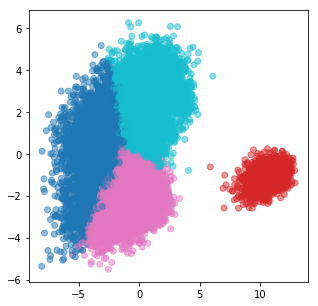

In [29]:
fig = plt.figure(figsize=(5, 5))

plt.scatter(X_decomposition[:, 0], X_decomposition[:,1], c = y_pred,
                 cmap = plt.cm.get_cmap("tab10", 10), alpha = 0.5)

In [30]:
print(metrics.calinski_harabasz_score(X, y_pred))

10729.453247311398


In [31]:
list(Y[10:20])

[3, 2, 1, 2, 2, 3, 3, 2, 0, 0]

Confusion matrix, without normalization
[[   0 2025    0    0]
 [1532    0   60 4274]
 [3354    0 2454 1030]
 [ 581    0 2816   21]]


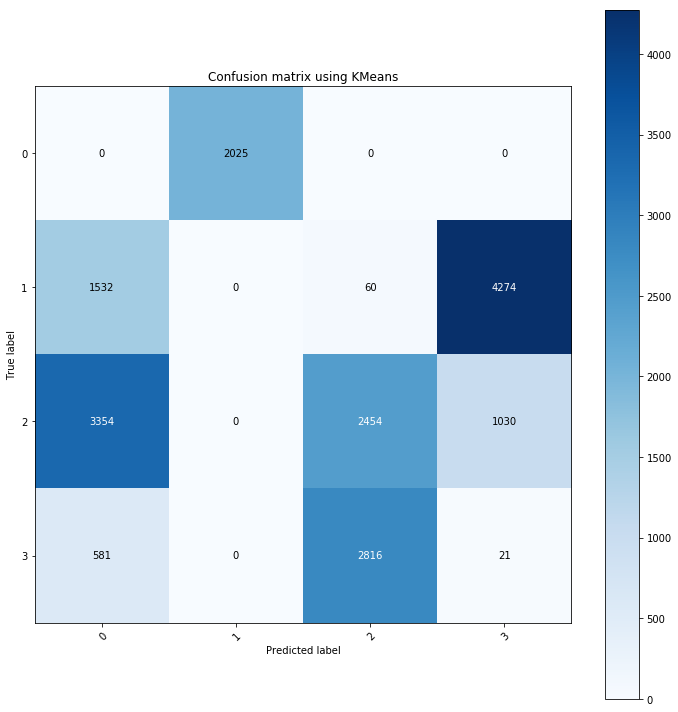

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10,10))    

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# print(classification_report(list(Y), y_pred))

plot_confusion_matrix(list(Y), y_pred, classes=np.array(["0","1","2","3"]), title='Confusion matrix using KMeans')